In [ ]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.15.2 / PyTorch 2.6.0


In [3]:

BATCH_SIZE = 32

def load_datasets(partition_id, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    for param in previous_net.parameters():
        param.requires_grad = False

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for _, (x, target) in enumerate(train_loader):
            x, target = x, target
            optimizer.zero_grad()
            x.requires_grad = False
            target.requires_grad = False
            target = target.long()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            _, pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            _, pro2, _ = global_net(x)
            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # pro 3 is the representation by the previous model (Line 16 of Algorithm 1)
            _, pro3, _ = previous_net(x)
            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).cuda().long()
            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)
            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)
            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )






def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        for idx, (name, param) in enumerate(model.named_parameters()):
            if idx == trainable_layers or trainable_layers == -1:
                param.requires_grad = True
            else:
                param.requires_grad = False

In [8]:

NETWORK_LEN = len(Net().state_dict().keys())
EPOCHS = 2
NUM_PARTITIONS = 3
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 5
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 25


# Normal FedAvg

In [57]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_avg_result = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)

        if fed_avg_result.get(server_round):
            fed_avg_result[server_round]["total_size"] = total_size
        else:
            fed_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 

        if fed_avg_result.get(server_round):
            fed_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [58]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [59]:
def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout


INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 2] fit, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=25879) Epoch 1: train loss 0.05709664523601532, accuracy 0.3283078307830783
(ClientAppActor pid=25880) [Client 1] fit, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) Epoch 2: train loss 0.048563286662101746, accuracy 0.4317857946448661 [repeated 5x across cluster]
(ClientAppActor pid=25881) [Client 0] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 0] fit, config: {}
(ClientAppActor pid=25879) Epoch 1: train loss 0.04688112437725067, accuracy 0.4509112727818195
(ClientAppActor pid=25879) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) Epoch 2: train loss 0.042869411408901215, accuracy 0.49804980498049806 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 0] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 2] fit, config: {}
(ClientAppActor pid=25881) Epoch 2: train loss 0.04348791390657425, accuracy 0.4963624090602265
(ClientAppActor pid=25880) Epoch 1: train loss 0.04189232364296913, accuracy 0.5199879996999925
(ClientAppActor pid=25880) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25879) [Client 1] fit, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) Epoch 2: train loss 0.039682306349277496, accuracy 0.5447386184654617 [repeated 3x across cluster]
(ClientAppActor pid=25879) [Client 0] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 0] fit, config: {}
(ClientAppActor pid=25881) Epoch 2: train loss 0.03890926018357277, accuracy 0.5495049504950495 [repeated 2x across cluster]
(ClientAppActor pid=25880) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25879) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 1: train loss 0.038877326995134354, accuracy 0.554788869721743
(ClientAppActor pid=25880) Epoch 1: train loss 0.0387711301445961, accuracy 0.5572639315982899


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) Epoch 2: train loss 0.03598763793706894, accuracy 0.5879087908790879 [repeated 4x across cluster]
(ClientAppActor pid=25881) [Client 2] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 0] fit, config: {}
(ClientAppActor pid=25880) [Client 1] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=25880) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=25880)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=25880) Epoch 1: train loss 0.03661688417196274, accuracy 0.5824645616140404
(ClientAppActor pid=25881) [Client 2] fit, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) Epoch 2: train loss 0.03373777121305466, accuracy 0.6179867986798679 [repeated 5x across cluster]
(ClientAppActor pid=25879) [Client 1] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 1] fit, config: {}
(ClientAppActor pid=25879) Epoch 1: train loss 0.03436029329895973, accuracy 0.6080402010050251
(ClientAppActor pid=25881) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 2: train loss 0.032098397612571716, accuracy 0.6349658741468537 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 0] evaluate, config: {}


(ClientAppActor pid=25880) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25880)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 0] fit, config: {}
(ClientAppActor pid=25880) Epoch 2: train loss 0.03141256049275398, accuracy 0.6398889888988899
(ClientAppActor pid=25881) Epoch 1: train loss 0.032524704933166504, accuracy 0.6267156678916973
(ClientAppActor pid=25879) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 2: train loss 0.030041348189115524, accuracy 0.6566414160354009 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 1] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 0] fit, config: {}
(ClientAppActor pid=25880) Epoch 2: train loss 0.029605073854327202, accuracy 0.6656165616561656 [repeated 2x across cluster]
(ClientAppActor pid=25880) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25879) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) Epoch 1: train loss 0.03119714744389057, accuracy 0.6513162829070727
(ClientAppActor pid=25881) Epoch 1: train loss 0.030779048800468445, accuracy 0.6526402640264026


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) Epoch 2: train loss 0.02852047234773636, accuracy 0.6716417910447762 [repeated 4x across cluster]
(ClientAppActor pid=25881) [Client 1] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 2] fit, config: {}
(ClientAppActor pid=25881) Epoch 1: train loss 0.029315244406461716, accuracy 0.6676417641764176
(ClientAppActor pid=25879) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25879) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 2: train loss 0.026575583964586258, accuracy 0.7006450645064507 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 2] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 2] fit, config: {}
(ClientAppActor pid=25879) Epoch 2: train loss 0.027124939486384392, accuracy 0.6914422860571514 [repeated 2x across cluster]
(ClientAppActor pid=25880) 
(ClientAppActor pid=25879) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25879) Epoch 1: train loss 0.02875450998544693, accuracy 0.6777169429235731
(ClientAppActor pid=25881) Epoch 1: train loss 0.028134679421782494, accuracy 0.6828682868286828


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) Epoch 2: train loss 0.025426430627703667, accuracy 0.7118427960699018 [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 2] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=25880) Epoch 2: train loss 0.025565465912222862, accuracy 0.7094427360684017 [repeated 2x across cluster]
(ClientAppActor pid=25879) [Client 1] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=25880, ip=127.0.0.1, actor_id=d9ca95b7c981e4126db53b1901000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x121961b50>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppA

(ClientAppActor pid=25881) [Client 2] fit, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=25881) Epoch 1: train loss 0.02684873715043068, accuracy 0.6975697569756976
(ClientAppActor pid=25881) Epoch 2: train loss 0.023992806673049927, accuracy 0.7281728172817282


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=25880, ip=127.0.0.1, actor_id=d9ca95b7c981e4126db53b1901000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x121961b50>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/uoft-cs/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=25880, ip=127.0.0.1, actor_id=d9ca95b7c981e4126db53b1901000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x121961b50>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/flwr/simulation/ray_transport

(ClientAppActor pid=25879) [Client 1] fit, config: {}
(ClientAppActor pid=25879) Epoch 1: train loss 0.026996206492185593, accuracy 0.6909922748068702


INFO :      aggregate_fit: received 2 results and 1 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) Epoch 2: train loss 0.02420017123222351, accuracy 0.7247431185779645
(ClientAppActor pid=25879) [Client 0] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 0] fit, config: {}
(ClientAppActor pid=25879) Epoch 1: train loss 0.024812383577227592, accuracy 0.7184968496849685
(ClientAppActor pid=25881) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) [Client 1] fit, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) Epoch 2: train loss 0.022201960906386375, accuracy 0.7438685967149179 [repeated 5x across cluster]
(ClientAppActor pid=25879) [Client 2] evaluate, config: {}
(ClientAppActor pid=25881) [Client 1] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 0] fit, config: {}
(ClientAppActor pid=25881) Epoch 1: train loss 0.02403821237385273, accuracy 0.7246681167029175
(ClientAppActor pid=25880) [Client 0] evaluate, config: {}
(ClientAppActor pid=25879) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) Epoch 1: train loss 0.026721352711319923, accuracy 0.6944423610590265
(ClientAppActor pid=25880) Epoch 2: train loss 0.02356571890413761, accuracy 0.7325433135828395 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 1] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 0] fit, config: {}
(ClientAppActor pid=25879) Epoch 2: train loss 0.02095956727862358, accuracy 0.7614761476147615 [repeated 2x across cluster]
(ClientAppActor pid=25879) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 1: train loss 0.023140255361795425, accuracy 0.7373987398739874 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) Epoch 2: train loss 0.0199465099722147, accuracy 0.7725193129828246 [repeated 4x across cluster]
(ClientAppActor pid=25881) [Client 1] evaluate, config: {}


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 0] fit, config: {}
(ClientAppActor pid=25879) Epoch 1: train loss 0.024601418524980545, accuracy 0.715367884197105
(ClientAppActor pid=25879) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25879) Epoch 2: train loss 0.021049069240689278, accuracy 0.7627690692267307 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=25880) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25880)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=25880) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 1] fit, config: {}
(ClientAppActor pid=25881) Epoch 2: train loss 0.018805334344506264, accuracy 0.7860786078607861 [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 1: train loss 0.023430999368429184, accuracy 0.7344933623340584 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 1] evaluate, config: {}
(ClientAppActor pid=25881) Epoch 2: train loss 0.019975947216153145, accuracy 0.7735693392334808 [repeated 3x across cluster]


(ClientAppActor pid=25880) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25880)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 0] fit, config: {}
(ClientAppActor pid=25881) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 1: train loss 0.022450372576713562, accuracy 0.7441686042151053
(ClientAppActor pid=25879) Epoch 1: train loss 0.020613931119441986, accuracy 0.7611190279756994
(ClientAppActor pid=25880) [Client 2] fit, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 1] evaluate, config: {}
(ClientAppActor pid=25880) Epoch 2: train loss 0.01716463454067707, accuracy 0.8077557755775577 [repeated 4x across cluster]


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 0] fit, config: {}
(ClientAppActor pid=25880) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) Epoch 1: train loss 0.021740777418017387, accuracy 0.754068851721293
(ClientAppActor pid=25881) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 1: train loss 0.01958506368100643, accuracy 0.7749024902490249


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 0] evaluate, config: {}
(ClientAppActor pid=25879) Epoch 2: train loss 0.016408229246735573, accuracy 0.8096452411310283 [repeated 4x across cluster]


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 0] fit, config: {}
(ClientAppActor pid=25880) [Client 2] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=25880) Epoch 1: train loss 0.0207735076546669, accuracy 0.7618690467261682
(ClientAppActor pid=25879) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 2: train loss 0.01555720902979374, accuracy 0.8219455486387159 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 0] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=25880) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=25880)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 1] fit, config: {}
(ClientAppActor pid=25879) Epoch 2: train loss 0.01551945973187685, accuracy 0.8229072907290729
(ClientAppActor pid=25880) Epoch 1: train loss 0.01837860234081745, accuracy 0.7888697217430436
(ClientAppActor pid=25881) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 0] fit, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=25880) Epoch 2: train loss 0.014774352312088013, accuracy 0.8319957998949974 [repeated 3x across cluster]


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 1] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 2] fit, config: {}
(ClientAppActor pid=25881) Epoch 2: train loss 0.016302218660712242, accuracy 0.8139953498837471 [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) Epoch 1: train loss 0.01778879016637802, accuracy 0.7964296429642964
(ClientAppActor pid=25879) Epoch 1: train loss 0.01786040887236595, accuracy 0.7929198229955748
(ClientAppActor pid=25880) Epoch 2: train loss 0.014101507142186165, accuracy 0.8403090309030903 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 1] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25881) [Client 0] fit, config: {}
(ClientAppActor pid=25881) Epoch 2: train loss 0.015488499775528908, accuracy 0.8245706142653566 [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25879) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25879) Epoch 1: train loss 0.016779432073235512, accuracy 0.8101560156015601 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 0] evaluate, config: {}
(ClientAppActor pid=25879) Epoch 2: train loss 0.013353749178349972, accuracy 0.849084908490849 [repeated 3x across cluster]


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 0] fit, config: {}
(ClientAppActor pid=25880) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) Epoch 1: train loss 0.01766948588192463, accuracy 0.796444911122778
(ClientAppActor pid=25879) Epoch 1: train loss 0.01619577594101429, accuracy 0.8145064506450646
(ClientAppActor pid=25881) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25880) Epoch 2: train loss 0.014124086126685143, accuracy 0.8378459461486537 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 1] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 2] fit, config: {}
(ClientAppActor pid=25881) Epoch 2: train loss 0.012810817919671535, accuracy 0.8526213155328883 [repeated 2x across cluster]
(ClientAppActor pid=25881) [Client 0] evaluate, config: {} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25880) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=25881) Epoch 2: train loss 0.01333713624626398, accuracy 0.8469961749043726 [repeated 4x across cluster]
(ClientAppActor pid=25879) [Client 0] evaluate, config: {}
(ClientAppActor pid=25880) [Client 2] evaluate, config: {}


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 2] fit, config: {}
(ClientAppActor pid=25879) Epoch 2: train loss 0.01167143415659666, accuracy 0.864986498649865 [repeated 2x across cluster]
(ClientAppActor pid=25880) [Client 1] fit, config: {}
(ClientAppActor pid=25881) [Client 1] evaluate, config: {}
(ClientAppActor pid=25881) Epoch 1: train loss 0.01660754717886448, accuracy 0.8055201380034501 [repeated 3x across cluster]
(ClientAppActor pid=25881) [Client 0] fit, config: {}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=25879) [Client 2] evaluate, config: {}
(ClientAppActor pid=25881) Epoch 2: train loss 0.012540544383227825, accuracy 0.8553213830345758 [repeated 3x across cluster]


(ClientAppActor pid=25879) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=25879)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 431.84s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05129404053452539
INFO :      		round 2: 0.04222456230995203
INFO :      		round 3: 0.03988477584720254
INFO :      		round 4: 0.03706474076912561
INFO :      		round 5: 0.035949428661707236
INFO :      		round 6: 0.035322749788726335
INFO :      		round 7: 0.03490221149991499
INFO :      		round 8: 0.034308579314401025
INFO :      		round 9: 0.03411491619863646
INFO :      		round 10: 0.03418913024159771
INFO :      		round 11: 0.0350

(ClientAppActor pid=25881) [Client 0] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=25881) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=25881)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


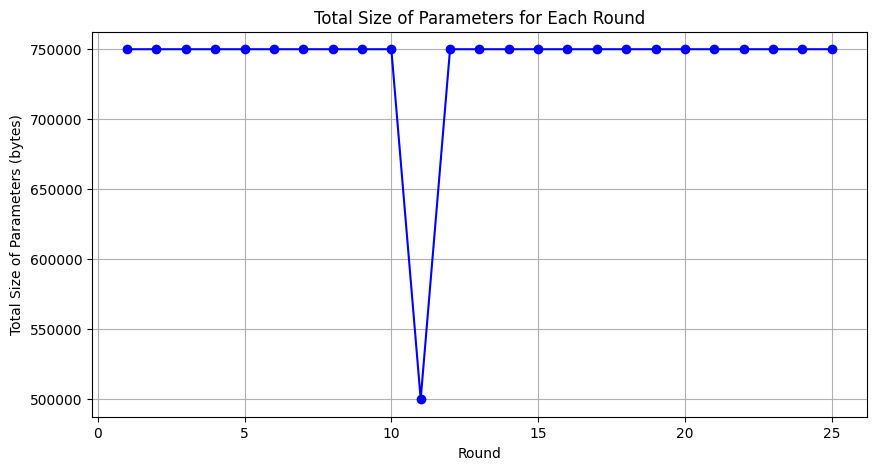

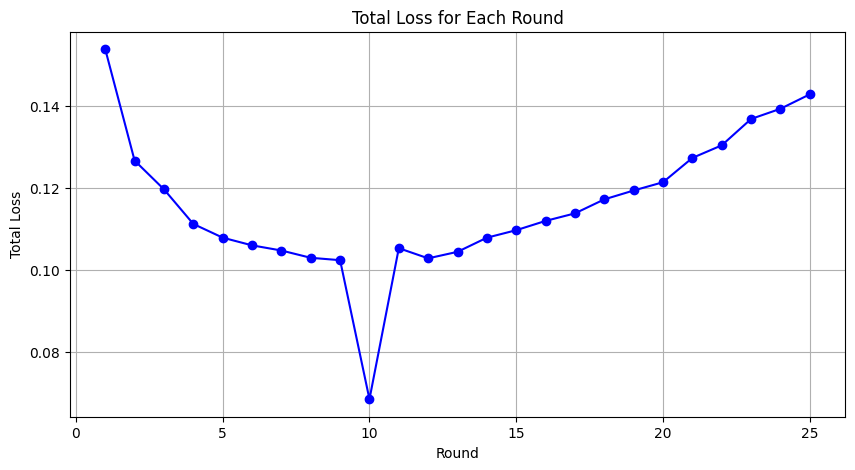

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.grid(True)


# FedAvgPart Experiments

In [66]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [67]:
class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedAvgPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [68]:


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 1] fit, config: {'trainable_layers': -1}


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=38688) Epoch 1: train loss 0.05830937996506691, accuracy 0.3030075751893797
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=38688) [Client 1] get_parameters
(ClientAppActor pid=38688) Epoch 2: train loss 0.04884054884314537, accuracy 0.43036075901897547 [repeated 3x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 749760
(ClientAppActor pid=38688) [Client 1] evaluate, config: {}


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=38687) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 2: train loss 0.047628823667764664, accuracy 0.4411941194119412 [repeated 2x across cluster]
(ClientAppActor pid=38687) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38689) [Client 1] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=38688) Epoch 1: train loss 0.04673757776618004, accuracy 0.45102010201020104
(ClientAppActor pid=38687) Epoch 1: train loss 0.04727163165807724, accuracy 0.4411610290257256


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38688) [Client 2] get_parameters
total size: 749760
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.04329189658164978, accuracy 0.4961374034350859 [repeated 4x across cluster]
(ClientAppActor pid=38687) [Client 2] evaluate, config: {}


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38689) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=38689) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38689) Epoch 1: train loss 0.04165268689393997, accuracy 0.5179629490737269
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 1: train loss 0.041343312710523605, accuracy 0.5144014401440145
(ClientAppActor pid=38689) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38688) Epoch 2: train loss 0.039009686559438705, accuracy 0.5483387084677117 [repeated 3x across cluster]
total size: 749760


(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=38688) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 2: train loss 0.038495637476444244, accuracy 0.555955595559556
(ClientAppActor pid=38689) Epoch 1: train loss 0.03838976100087166, accuracy 0.5581639540988524
(ClientAppActor pid=38688) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=38689) [Client 1] get_parameters
(ClientAppActor pid=38688) Epoch 2: train loss 0.03568367660045624, accuracy 0.5925148128703217 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 749760


(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=38687) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 2: train loss 0.035423241555690765, accuracy 0.5963096309630963
(ClientAppActor pid=38687) Epoch 1: train loss 0.035349536687135696, accuracy 0.594959495949595
(ClientAppActor pid=38688) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=38687) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38688) Epoch 2: train loss 0.033070698380470276, accuracy 0.6231905797644941 [repeated 5x across cluster]
total size: 749760
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 2] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=38688) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38688) Epoch 1: train loss 0.031303972005844116, accuracy 0.6455145514551455
(ClientAppActor pid=38689) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38687) [Client 1] fit, config: {'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=38688) [Client 2] get_parameters
(ClientAppActor pid=38689) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 6453


(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) Epoch 2: train loss 0.03176010027527809, accuracy 0.6373659341483537 [repeated 5x across cluster]
(ClientAppActor pid=38687) [Client 0] evaluate, config: {}
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38689) [Client 1] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=38687) [Client 1] get_parameters
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=38689) Epoch 1: train loss 0.03179009631276131, accuracy 0.6372909322733068
(ClientAppActor pid=38688) [Client 2] evaluate, config: {}
(ClientAppActor pid=38687) Epoch 1: train loss 0.031212691217660904, accuracy 0.6473897389738974


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38689) [Client 1] get_parameters
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 0}
total size: 6453


(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) [Client 1] evaluate, config: {}
(ClientAppActor pid=38687) Epoch 2: train loss 0.031208232045173645, accuracy 0.6506150615061506 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38689) [Client 0] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=38687) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38689) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38689) Epoch 1: train loss 0.03098328597843647, accuracy 0.6483162079051976
(ClientAppActor pid=38687) Epoch 1: train loss 0.030775906518101692, accuracy 0.6564656465646564
(ClientAppActor pid=38688) [Client 1] fit, config: {'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=38689) [Client 0] get_parameters
(ClientAppActor pid=38687) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1125
(ClientAppActor pid=38689) [Client 2] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 2: train loss 0.0313248410820961, accuracy 0.6395409885247131 [repeated 4x across cluster]
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}


(ClientAppActor pid=38689) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38689)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 1] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=38688) [Client 1] get_parameters
(ClientAppActor pid=38687) [Client 0] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=38687) Epoch 1: train loss 0.030959686264395714, accuracy 0.6499662491562289
(ClientAppActor pid=38687) [Client 1] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 1: train loss 0.03132657706737518, accuracy 0.6406660166504162
(ClientAppActor pid=38687) [Client 0] get_parameters
(ClientAppActor pid=38689) [Client 2] fit, config: {'trainable_layers': 1}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1125
(ClientAppActor pid=38689) [Client 0] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.03077128157019615, accuracy 0.6553405340534053 [repeated 4x across cluster]


(ClientAppActor pid=38689) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38689)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=38688, ip=127.0.0.1, actor_id=9af1a73064c95deb5b8810df01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x102e61a30>)
  File "/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 504 Server Error: Gateway Time-out for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the

Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=38688) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=38688) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Mon Feb 10 19:26:19 2025).
(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=38689) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38687) [Client 2] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 1: train loss 0.031442102044820786, accuracy 0.6445661141528538
(ClientAppActor pid=38689) [Client 2] fit, config: {'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=38687) [Client 1] get_parameters
(ClientAppActor pid=38688) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 29853
(ClientAppActor pid=38689) [Client 0] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.03091793693602085, accuracy 0.6531653165316532 [repeated 5x across cluster]


(ClientAppActor pid=38687) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=38687) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Mon Feb 10 19:26:19 2025).
(ClientAppActor pid=38689) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=38689)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=38689) [Client 2] get_parameters
(ClientAppActor pid=38687) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=38688) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38688) Epoch 1: train loss 0.031172754243016243, accuracy 0.6446411160279008
(ClientAppActor pid=38687) Epoch 1: train loss 0.03156738728284836, accuracy 0.6380409510237756


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38688) [Client 0] get_parameters
(ClientAppActor pid=38689) [Client 2] fit, config: {'trainable_layers': 2}
total size: 29853
(ClientAppActor pid=38689) [Client 0] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.03068721480667591, accuracy 0.6575907590759076 [repeated 4x across cluster]
(ClientAppActor pid=38688) [Client 1] evaluate, config: {}


(ClientAppActor pid=38689) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38689)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=38689) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38688) Epoch 1: train loss 0.030389454215765, accuracy 0.6567164179104478
(ClientAppActor pid=38687) [Client 2] evaluate, config: {}
(ClientAppActor pid=38687) Epoch 1: train loss 0.030694101005792618, accuracy 0.6478661966549164


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38689) [Client 2] fit, config: {'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=38688) [Client 0] get_parameters
(ClientAppActor pid=38687) [Client 1] get_parameters
total size: 1245


(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) [Client 0] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.030185233801603317, accuracy 0.661941194119412 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=38689) [Client 2] get_parameters
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=38688) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 1: train loss 0.03020387329161167, accuracy 0.6622412241224123
(ClientAppActor pid=38689) Epoch 1: train loss 0.030667481943964958, accuracy 0.6477911947798695
(ClientAppActor pid=38687) [Client 2] get_parameters
(ClientAppActor pid=38689) [Client 1] fit, config: {'trainable_layers': 3}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1245


(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) [Client 2] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.030679717659950256, accuracy 0.6483912097802446 [repeated 4x across cluster]
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38689) [Client 1] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=38689) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38689) Epoch 1: train loss 0.03165865316987038, accuracy 0.6388659716492913
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}
(ClientAppActor pid=38687) Epoch 1: train loss 0.031280823051929474, accuracy 0.6434893489348935
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=38689) [Client 1] get_parameters
(ClientAppActor pid=38687) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 577053
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 2: train loss 0.029124505817890167, accuracy 0.6679666991674792 [repeated 4x across cluster]


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 1] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=38688) [Client 0] get_parameters
(ClientAppActor pid=38687) [Client 0] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=38687) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38688) Epoch 1: train loss 0.030385445803403854, accuracy 0.6556663916597915
(ClientAppActor pid=38689) Epoch 1: train loss 0.030001500621438026, accuracy 0.6647164716471647


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38688) [Client 1] get_parameters
(ClientAppActor pid=38689) [Client 2] fit, config: {'trainable_layers': 4}
total size: 577053
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.027902431786060333, accuracy 0.6816681668166816 [repeated 4x across cluster]
(ClientAppActor pid=38687) [Client 1] evaluate, config: {}


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=38689) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38688) Epoch 1: train loss 0.028217049315571785, accuracy 0.6813920348008701
(ClientAppActor pid=38689) [Client 2] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 1: train loss 0.02783859893679619, accuracy 0.6875421885547138
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': 5} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 2493
(ClientAppActor pid=38687) [Client 2] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}
(ClientAppActor pid=38687) Epoch 2: train loss 0.027693770825862885, accuracy 0.6951695169516952 [repeated 4x across cluster]


(ClientAppActor pid=38689) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38689)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 1] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=38687) [Client 0] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=38687) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 1: train loss 0.027727283537387848, accuracy 0.688667216680417
(ClientAppActor pid=38688) Epoch 1: train loss 0.02811601012945175, accuracy 0.6810920273006825


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38687) [Client 0] get_parameters
(ClientAppActor pid=38689) [Client 2] fit, config: {'trainable_layers': 5}
total size: 2493
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}
(ClientAppActor pid=38687) [Client 2] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.027650045230984688, accuracy 0.6954695469546954 [repeated 4x across cluster]


(ClientAppActor pid=38689) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38689)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38689) [Client 2] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=38689) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38687) Epoch 1: train loss 0.028223149478435516, accuracy 0.6779419485487137
(ClientAppActor pid=38689) Epoch 1: train loss 0.027812466025352478, accuracy 0.6891689168916891
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 6} [repeated 2x across cluster]
(ClientAppActor pid=38687) [Client 1] get_parameters
(ClientAppActor pid=38689) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 122013
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 2: train loss 0.027223851531744003, accuracy 0.6927923198079952 [repeated 4x across cluster]


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=38688) [Client 0] get_parameters
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=38689) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 1: train loss 0.027369491755962372, accuracy 0.6932193219321933
(ClientAppActor pid=38689) Epoch 1: train loss 0.027780260890722275, accuracy 0.6829670741768544
(ClientAppActor pid=38687) [Client 2] get_parameters
(ClientAppActor pid=38689) [Client 1] fit, config: {'trainable_layers': 6}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 122013
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 2: train loss 0.026859035715460777, accuracy 0.6981924548113703 [repeated 4x across cluster]
(ClientAppActor pid=38687) [Client 2] evaluate, config: {}


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38687) [Client 1] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=38688) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 1: train loss 0.027204232290387154, accuracy 0.6906172654316358
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 1: train loss 0.026788614690303802, accuracy 0.7029702970297029
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 7} [repeated 2x across cluster]
(ClientAppActor pid=38687) [Client 1] get_parameters
(ClientAppActor pid=38689) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 2061


(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) [Client 2] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 2: train loss 0.026768509298563004, accuracy 0.698942473561839 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=38688) [Client 0] get_parameters
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=38688) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38688) Epoch 1: train loss 0.026763897389173508, accuracy 0.6991674791869796
(ClientAppActor pid=38687) Epoch 1: train loss 0.026767225936055183, accuracy 0.7033453345334534


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38687) [Client 2] get_parameters
(ClientAppActor pid=38689) [Client 1] fit, config: {'trainable_layers': 7}
total size: 2061
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.02719281241297722, accuracy 0.6919672991824796 [repeated 4x across cluster]
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38687) [Client 0] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=38689) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38689) Epoch 1: train loss 0.0273808054625988, accuracy 0.6893422335558389
(ClientAppActor pid=38687) [Client 2] evaluate, config: {}
(ClientAppActor pid=38687) Epoch 1: train loss 0.026965776458382607, accuracy 0.6966924173104327
(ClientAppActor pid=38688) [Client 2] fit, config: {'trainable_layers': 8} [repeated 2x across cluster]
(ClientAppActor pid=38689) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38687) [Client 0] get_parameters
total size: 11133
(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 2: train loss 0.026821628212928772, accuracy 0.700945094509451 [repeated 4x across cluster]


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38687) [Client 1] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=38688) [Client 2] get_parameters
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=38689) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 1: train loss 0.027339858934283257, accuracy 0.6885172129303233
(ClientAppActor pid=38688) Epoch 1: train loss 0.026881445199251175, accuracy 0.6978174454361359


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=38687) [Client 1] get_parameters
(ClientAppActor pid=38689) [Client 2] fit, config: {'trainable_layers': 8}
total size: 11133


INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=38688) [Client 0] evaluate, config: {}
(ClientAppActor pid=38687) [Client 2] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.02677200920879841, accuracy 0.6995949594959496 [repeated 4x across cluster]


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38688) [Client 2] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=38689) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}
(ClientAppActor pid=38688) Epoch 1: train loss 0.026671379804611206, accuracy 0.7037203720372037
(ClientAppActor pid=38687) Epoch 1: train loss 0.02714511938393116, accuracy 0.6900172504312608
(ClientAppActor pid=38689) [Client 0] fit, config: {'trainable_layers': 9} [repeated 2x across cluster]
(ClientAppActor pid=38688) [Client 2] get_parameters
(ClientAppActor pid=38687) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1173


(ClientAppActor pid=38687) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38687)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) [Client 2] evaluate, config: {}
(ClientAppActor pid=38689) Epoch 2: train loss 0.026652028784155846, accuracy 0.7017175429385735 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=38687) [Client 2] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=38689) [Client 0] get_parameters
(ClientAppActor pid=38689) [Client 1] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=38688) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38687) Epoch 1: train loss 0.026626503095030785, accuracy 0.7045454545454546
(ClientAppActor pid=38689) Epoch 1: train loss 0.027115827426314354, accuracy 0.691067276681917
(ClientAppActor pid=38687) [Client 2] get_parameters
(ClientAppActor pid=38688) [Client 0] fit, config: {'trainable_layers': 9}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1173


(ClientAppActor pid=38688) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38688)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38687) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38688) Epoch 2: train loss 0.026637911796569824, accuracy 0.7006675166879172 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 352.94s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05509071501701551
INFO :      		round 2: 0.04227605158747303
INFO :      		round 3: 0.039273952155369704
INFO :      		round 4: 0.03761660146894419
INFO :      		round 5: 0.03597828717535435
INFO :      		round 6: 0.03597966792094329
INFO :      		round 7: 0.03597982652996378
INFO :      		round 8: 0.03596139628454295
INFO :      		round 9: 0.03597178626146299
INFO :      		round 10: 0.03589019110812542
INFO :      		round 11: 0.03585829864535611
INFO :      		round 12: 0.03576107691154792
INFO :      		round 13: 0.03575646396971445
INFO :      		round 14: 0.035122878976140914
INFO :      		round 15: 0.03488825858116055
INFO :      		round 16: 0.03475648771701062
INFO :      		round 17: 0.03477026942884224
INFO :      		round 18: 0.034912153205450144
INFO :      		round 19:

(ClientAppActor pid=38688) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=38689) [Client 1] evaluate, config: {}


(ClientAppActor pid=38689) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=38689)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


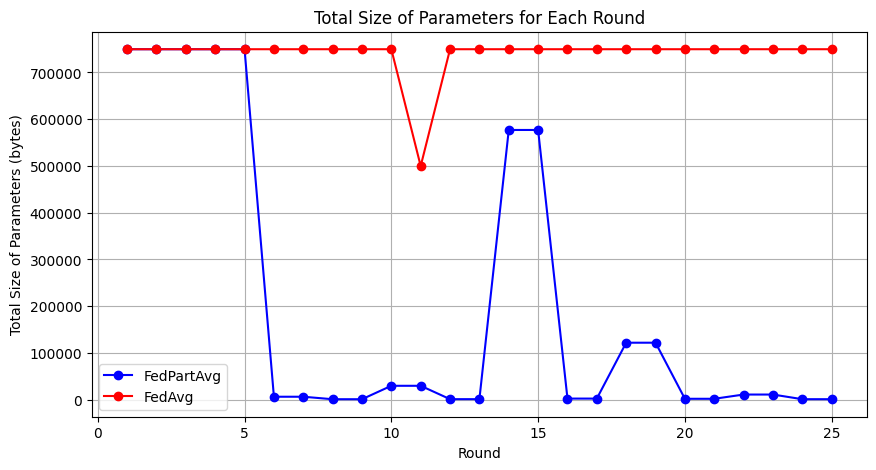

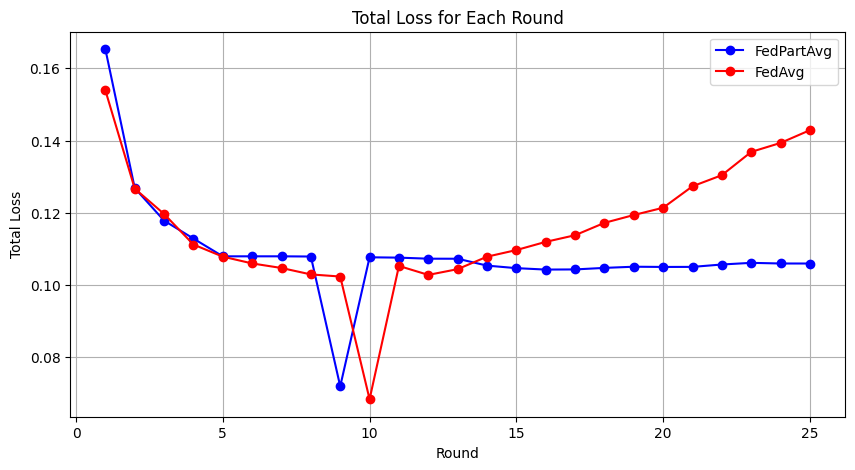

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)

# FedProxPart Experiments

In [71]:
class FedProxPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [73]:
fed_part_prox_result = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated


In [74]:
def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}


(ClientAppActor pid=63851) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=63851)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=63851) Epoch 1: train loss 0.05892866849899292, accuracy 0.3021075526888172
(ClientAppActor pid=63852) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63851) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=63850) Epoch 2: train loss 0.04914848506450653, accuracy 0.4233423342334233 [repeated 4x across cluster]
total size: 749760


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=63850) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63852) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63852) Epoch 2: train loss 0.0489773191511631, accuracy 0.4275106877671942
(ClientAppActor pid=63851) Epoch 1: train loss 0.046586088836193085, accuracy 0.45304530453045305
(ClientAppActor pid=63852) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63851) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=63852) Epoch 2: train loss 0.042943768203258514, accuracy 0.5049126228155704 [repeated 4x across cluster]
total size: 749760


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63850) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63850) Epoch 2: train loss 0.04313352704048157, accuracy 0.49688742218555465
(ClientAppActor pid=63851) Epoch 1: train loss 0.041241567581892014, accuracy 0.5246381159528988
(ClientAppActor pid=63851) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63852) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63851) [Client 0] get_parameters
(ClientAppActor pid=63850) Epoch 2: train loss 0.03853287175297737, accuracy 0.5546388659716492 [repeated 4x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 749760


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63850) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63852) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63852) Epoch 2: train loss 0.03825351968407631, accuracy 0.5639063906390639
(ClientAppActor pid=63851) Epoch 1: train loss 0.03785380348563194, accuracy 0.5628140703517588
(ClientAppActor pid=63852) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63852) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=63850) [Client 2] get_parameters
(ClientAppActor pid=63852) Epoch 2: train loss 0.03542887419462204, accuracy 0.5967899197479937 [repeated 5x across cluster]
total size: 749760


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=63852) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63851) Epoch 1: train loss 0.03541094809770584, accuracy 0.5995649891247281
(ClientAppActor pid=63851) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 2x across cluster]
(ClientAppActor pid=63851) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=63850) Epoch 2: train loss 0.032663214951753616, accuracy 0.6234155853896347 [repeated 5x across cluster]
total size: 749760


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63850) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=63850) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63851) Epoch 1: train loss 0.031099466606974602, accuracy 0.6462911572789319
(ClientAppActor pid=63851) [Client 2] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63852) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 1] get_parameters
(ClientAppActor pid=63851) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 6453


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) Epoch 2: train loss 0.030747782438993454, accuracy 0.6467896789678967 [repeated 5x across cluster]
(ClientAppActor pid=63852) [Client 0] evaluate, config: {}
(ClientAppActor pid=63850) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63852) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=63852) [Client 2] get_parameters
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=63852) Epoch 1: train loss 0.03090638667345047, accuracy 0.6462161554038851
(ClientAppActor pid=63851) [Client 2] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.03071267157793045, accuracy 0.6484398439843985


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=63852) [Client 1] get_parameters
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
total size: 6453
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.030814271420240402, accuracy 0.6527413185329634 [repeated 4x across cluster]


(ClientAppActor pid=63851) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63851)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63850) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=63851) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63850) Epoch 1: train loss 0.03051006607711315, accuracy 0.6537163429085727
(ClientAppActor pid=63852) Epoch 1: train loss 0.030547644942998886, accuracy 0.6528913222830571
(ClientAppActor pid=63851) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 0] get_parameters
(ClientAppActor pid=63852) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1125
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.03036019764840603, accuracy 0.653015301530153 [repeated 4x across cluster]
(ClientAppActor pid=63850) [Client 2] evaluate, config: {}


(ClientAppActor pid=63851) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63851)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=63851) [Client 2] get_parameters
(ClientAppActor pid=63852) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=63852) Epoch 1: train loss 0.030513836070895195, accuracy 0.6525163129078227
(ClientAppActor pid=63852) [Client 1] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.030545853078365326, accuracy 0.6543913597839947


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=63852) [Client 0] get_parameters
(ClientAppActor pid=63850) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
total size: 1125


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.030361676588654518, accuracy 0.6527152715271527 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63852) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=63851) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63852) Epoch 1: train loss 0.0307785477489233, accuracy 0.6482898289828983
(ClientAppActor pid=63850) Epoch 1: train loss 0.031088436022400856, accuracy 0.6481662041551038
(ClientAppActor pid=63851) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 2x across cluster]
(ClientAppActor pid=63852) [Client 2] get_parameters
(ClientAppActor pid=63850) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 29853


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63850) [Client 1] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.030786175280809402, accuracy 0.6479411985299632 [repeated 4x across cluster]
(ClientAppActor pid=63852) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=63851) [Client 1] get_parameters
(ClientAppActor pid=63852) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=63852) Epoch 1: train loss 0.03073100931942463, accuracy 0.6484662116552914
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.030516721308231354, accuracy 0.6564656465646564
(ClientAppActor pid=63852) [Client 1] get_parameters
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 29853


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.03049943968653679, accuracy 0.6556663916597915 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=63851) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63850) Epoch 1: train loss 0.029714195057749748, accuracy 0.6632913291329133
(ClientAppActor pid=63851) Epoch 1: train loss 0.029937366023659706, accuracy 0.6593414835370884
(ClientAppActor pid=63852) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 2] get_parameters
(ClientAppActor pid=63851) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1245
(ClientAppActor pid=63851) [Client 1] evaluate, config: {}
(ClientAppActor pid=63852) Epoch 2: train loss 0.02989785186946392, accuracy 0.6586664666616665 [repeated 4x across cluster]
(ClientAppActor pid=63852) [Client 0] evaluate, config: {}


(ClientAppActor pid=63851) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63851)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63852) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=63852) [Client 0] get_parameters
(ClientAppActor pid=63850) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=63852) Epoch 1: train loss 0.02988564968109131, accuracy 0.6591914797869947
(ClientAppActor pid=63850) [Client 2] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.029913270846009254, accuracy 0.6605415135378384
(ClientAppActor pid=63852) [Client 1] get_parameters
(ClientAppActor pid=63851) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1245


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.029663288965821266, accuracy 0.6638163816381638 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=63851) [Client 2] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63851) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63852) Epoch 1: train loss 0.030815649777650833, accuracy 0.6484662116552914
(ClientAppActor pid=63851) Epoch 1: train loss 0.030924787744879723, accuracy 0.6478661966549164
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 2x across cluster]
(ClientAppActor pid=63852) [Client 1] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=63850) [Client 2] get_parameters
total size: 577053


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.02855674736201763, accuracy 0.6754668866721668 [repeated 4x across cluster]
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63850) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=63851) [Client 0] get_parameters
(ClientAppActor pid=63851) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=63852) Epoch 1: train loss 0.02933427318930626, accuracy 0.6686168616861686
(ClientAppActor pid=63850) [Client 1] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.029586568474769592, accuracy 0.6666916672916823
(ClientAppActor pid=63852) [Client 2] get_parameters
(ClientAppActor pid=63852) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 577053


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63850) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.027235213667154312, accuracy 0.6936173404335109 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63852) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=63851) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63851) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63852) Epoch 1: train loss 0.0271877720952034, accuracy 0.6924923123078077
(ClientAppActor pid=63850) Epoch 1: train loss 0.027031557634472847, accuracy 0.6952445244524452
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 2x across cluster]
(ClientAppActor pid=63850) 
(ClientAppActor pid=63850) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 2493


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 1] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.027145644649863243, accuracy 0.6946673666841671 [repeated 4x across cluster]
(ClientAppActor pid=63850) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63852) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=63851) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=63852) Epoch 1: train loss 0.027072710916399956, accuracy 0.6933923348083703
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.026883723214268684, accuracy 0.6955445544554455
(ClientAppActor pid=63852) [Client 1] get_parameters
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=63850) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 2493


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.027104724198579788, accuracy 0.695342383559589 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63850) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=63851) [Client 0] get_parameters
(ClientAppActor pid=63850) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63850) Epoch 1: train loss 0.027290835976600647, accuracy 0.6909922748068702
(ClientAppActor pid=63852) Epoch 1: train loss 0.02700403705239296, accuracy 0.6947194719471947
(ClientAppActor pid=63852) [Client 2] get_parameters
(ClientAppActor pid=63851) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 122013


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63850) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.02638375759124756, accuracy 0.702617565439136 [repeated 4x across cluster]
(ClientAppActor pid=63852) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63852) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=63852) Epoch 1: train loss 0.0266092661768198, accuracy 0.6979674491862297
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.026495933532714844, accuracy 0.7016201620162016
(ClientAppActor pid=63852) [Client 1] get_parameters
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=63850) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 122013


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.026346664875745773, accuracy 0.7055426385659641 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63852) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=63851) [Client 0] get_parameters
(ClientAppActor pid=63851) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63850) Epoch 1: train loss 0.02602626010775566, accuracy 0.7043426085652141
(ClientAppActor pid=63852) Epoch 1: train loss 0.025983145460486412, accuracy 0.7055955595559555
(ClientAppActor pid=63852) [Client 2] get_parameters
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 2061
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.026238959282636642, accuracy 0.7030675766894172 [repeated 4x across cluster]


(ClientAppActor pid=63851) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63851)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63852) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=63850) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=63852) Epoch 1: train loss 0.02600114978849888, accuracy 0.7049426235655891
(ClientAppActor pid=63850) [Client 2] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.026240654289722443, accuracy 0.7023175579389485
(ClientAppActor pid=63852) [Client 1] get_parameters
(ClientAppActor pid=63851) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=63850) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 2061


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.025963520631194115, accuracy 0.7063456345634563 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=63851) [Client 2] get_parameters
(ClientAppActor pid=63851) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63852) Epoch 1: train loss 0.02617710269987583, accuracy 0.7025425635640891
(ClientAppActor pid=63850) Epoch 1: train loss 0.026121579110622406, accuracy 0.7043204320432043
(ClientAppActor pid=63852) [Client 1] get_parameters
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 11133


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63850) [Client 1] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.026274535804986954, accuracy 0.7040426010650266 [repeated 4x across cluster]
(ClientAppActor pid=63852) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=63852) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=63852) Epoch 1: train loss 0.026102665811777115, accuracy 0.7042676066901673
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.026062631979584694, accuracy 0.7068706870687068
(ClientAppActor pid=63852) [Client 1] get_parameters
(ClientAppActor pid=63851) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=63850) [Client 2] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 11133


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63850) [Client 2] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.02624616026878357, accuracy 0.7053176329408235 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63850) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=63851) [Client 0] get_parameters
(ClientAppActor pid=63852) [Client 1] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=63850) Epoch 1: train loss 0.025841545313596725, accuracy 0.709045904590459
(ClientAppActor pid=63851) Epoch 1: train loss 0.025893772020936012, accuracy 0.7052426310657767
(ClientAppActor pid=63850) [Client 2] get_parameters
(ClientAppActor pid=63852) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9} [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1173


(ClientAppActor pid=63852) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63852)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=63852) [Client 1] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.02588639408349991, accuracy 0.705617640441011 [repeated 4x across cluster]
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=63851) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=63852) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=63850) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=63852) Epoch 1: train loss 0.025818264111876488, accuracy 0.708970897089709
(ClientAppActor pid=63850) [Client 2] evaluate, config: {}
(ClientAppActor pid=63850) Epoch 1: train loss 0.026096360757946968, accuracy 0.7041176029400735
(ClientAppActor pid=63852) [Client 2] get_parameters
(ClientAppActor pid=63851) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=63850) [Client 0] get_parameters


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


total size: 1173
(ClientAppActor pid=63851) [Client 0] evaluate, config: {}
(ClientAppActor pid=63851) Epoch 2: train loss 0.02588285692036152, accuracy 0.7045676141903547 [repeated 4x across cluster]


(ClientAppActor pid=63851) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=63851)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 315.60s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05295316091038613
INFO :      		round 2: 0.04170572595628732
INFO :      		round 3: 0.03840648349679201
INFO :      		round 4: 0.03674312358414071
INFO :      		round 5: 0.03513992195652857
INFO :      		round 6: 0.03493044615816865
INFO :      		round 7: 0.03496414403025328
INFO :      		round 8: 0.03494619783271053
INFO :      		round 9: 0.034946624522589606
INFO :      		round 10: 0.03477156302602833
INFO :      		round 11: 0.034639

(ClientAppActor pid=63851) [Client 1] get_parameters
(ClientAppActor pid=63850) [Client 1] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=63850) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=63850)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


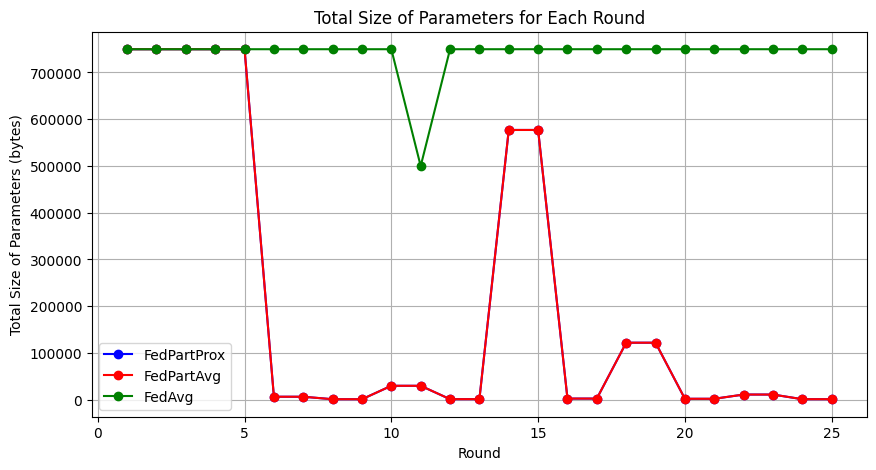

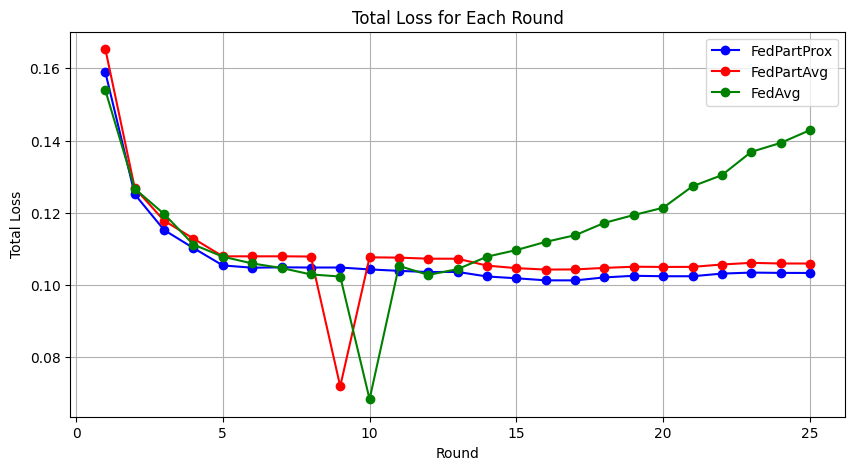

In [75]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


# FedMoon Experiments:

In [14]:
class FedMoonPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.previous_net = copy.deepcopy(net)

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return [get_parameters(self.net)[config["trainable_layers"]]]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        #TODO Need to add previous and global model  
        prev_model = "Need to find how to get previous model"
        global_model = "Need to add global Mode"

        freeze_layers(self.net, config["trainable_layers"])
        train_moon(self.net, self.trainloader, global_model,previous_net, EPOCHS, 5, 0.5 )
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)